# PIGPVAE cooling R4 model

In [1]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy
from torch.utils.data import Dataset, DataLoader,random_split, Subset
from tqdm import tqdm

sys.path.append(os.path.abspath('..'))
from physics import NewtonsLaw
from GP import *
from VAE_utils import AnnealingStrategy

from Models.PIGPVAE_lognorm import PIGPVAE

import warnings
# Suppress only the specific GPInputWarning coming from the exact_gp.py file
warnings.filterwarnings(
    "ignore", 
    message="The input matches the stored training data. Did you forget to call model.train()?", 
    module=".*exact_gp"
)


In [2]:
# Import RICO data 
file_path = '../Data/RICO4_Dataset_processed.hdf'
df = pd.read_hdf(file_path)
#  define surrounding temperature
df.loc[:, 'sur_temp'] = (df['RTD417'] + df['B.ASTRHT2.T'])/2
df_c = df.copy()
df_c = df[df['temp_change_class'] == 'c']
def select_points(group):
    return group.iloc[::10]  # Select every 10th row
df_c = df_c.groupby('Scheduler Step').apply(select_points).reset_index(drop=True)
df_c = df_c.dropna()

/var/folders/46/30710m094qv2_dhfs08nzzd00000gn/T/ipykernel_16315/3618831305.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_c = df_c.groupby('Scheduler Step').apply(select_points).reset_index(drop=True)


In [3]:
class RICO4Dataset(Dataset):
    def __init__(self, df, select_var):
        self.df = df
        self.select_var = select_var
        self.unique_batches = df['interval'].unique()

    def __len__(self):
        return len(self.unique_batches)

    def __getitem__(self, idx):
        batch = self.unique_batches[idx]
        temp = self.df[self.df['interval'] == batch][self.select_var]
        
        # Normalize and convert to tensors
        ti = torch.tensor(temp['time_within_interval'].to_numpy() / 240, dtype=torch.float32)
        Ts = torch.tensor(temp['sur_temp'].to_numpy(), dtype=torch.float32)
        heat_obs = torch.tensor(temp['B.RTD1'].to_numpy(), dtype=torch.float32)
        
        # Stack the tensors to create the input batch
        x_batch = torch.stack((heat_obs, Ts, ti), dim=1)
        
        return x_batch
# Initialize the dataset and train_loader
select_var = ['time_within_interval', 'sur_temp', 'B.RTD1']
dataset = RICO4Dataset(df_c,select_var)
# Define split ratios
train_ratio = 0.7
test_ratio = 1-train_ratio

# Calculate split sizes
total_size = len(dataset)
train_size = int(train_ratio * total_size)
test_size = total_size - train_size


seed = 0
generator = torch.Generator().manual_seed(seed)

# Split the dataset
train_subset, test_subset = random_split(
    dataset,
    [train_size, test_size],
    generator=generator
)
train_loader = DataLoader(train_subset, batch_size=1, shuffle=False)
val_loader = DataLoader(test_subset, batch_size=1, shuffle=False)

In [4]:
len(dataset)


28

In [5]:
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5))

# Initialize the GP_inference
GP_inf = GP_inference(kernel)

# Initialize the VAE
torch.manual_seed(1)
model = PIGPVAE(GP_inf=GP_inf, 
                hidden_layers_encoder_delta=[10,10], 
                hidden_layers_encoder_phy=[10], 
                hidden_layers_decoder_delta=[10,10],
                activation_decoder_delta=nn.ReLU(),
                trainable_alpha=True,
                initial_alpha=0.1
               )

In [6]:
gp_params = []
base_params = []
alpha_params = []

for name, param in model.named_parameters():
    if 'GP' in name:
        gp_params.append(param)  # Gaussian Process parameters
    elif 'raw_alpha' in name:
        alpha_params.append(param)  # raw_alpha parameter(s)
    else:
        base_params.append(param)  # All other parameters

# Define learning rates for each parameter group
base_lr = 0.001     # Learning rate for base parameters
gp_lr = 0.0001      # Learning rate for GP parameters
alpha_lr = 0.0001     # Learning rate for raw_alpha

# Create separate parameter groups in the optimizer
opt = torch.optim.Adam([
    {'params': base_params, 'lr': base_lr},
    {'params': gp_params, 'lr': gp_lr},
    {'params': alpha_params, 'lr': alpha_lr}
])
opt.zero_grad()


In [7]:
def find_rbf_lengthscale(kernel):
    if isinstance(kernel, gpytorch.kernels.RBFKernel):
        return kernel.lengthscale.item()
    elif hasattr(kernel, 'base_kernel'):
        return find_rbf_lengthscale(kernel.base_kernel)
    elif hasattr(kernel, 'kernels'):
        for k in kernel.kernels:
            result = find_rbf_lengthscale(k)
            if result is not None:
                return result
    return None

In [8]:
t_uni=torch.tensor(
    [  1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91., 101., 111.,
        121., 131., 141., 151., 161., 171., 181., 191., 201., 211., 221., 231.]
)


Training Progress:   5%|▍         | 28/600 [00:02<00:57, 10.03it/s]

Epoch 30: Train Loss = 1.6280, KL_phy = 0.1645, KL_delta = -0.2422, MSE = 1.6255, CE = 1.2529, Reg_Loss = 0.0455, Alpha = 0.0960
Validation Loss = 1.1419, Val_KL_phy = 0.1600, Val_KL_delta = -0.2249, Val_MSE = 1.1396, Val_CE = 1.2189, Val_Reg_Loss = 0.0399, Val_Alpha = 0.0960


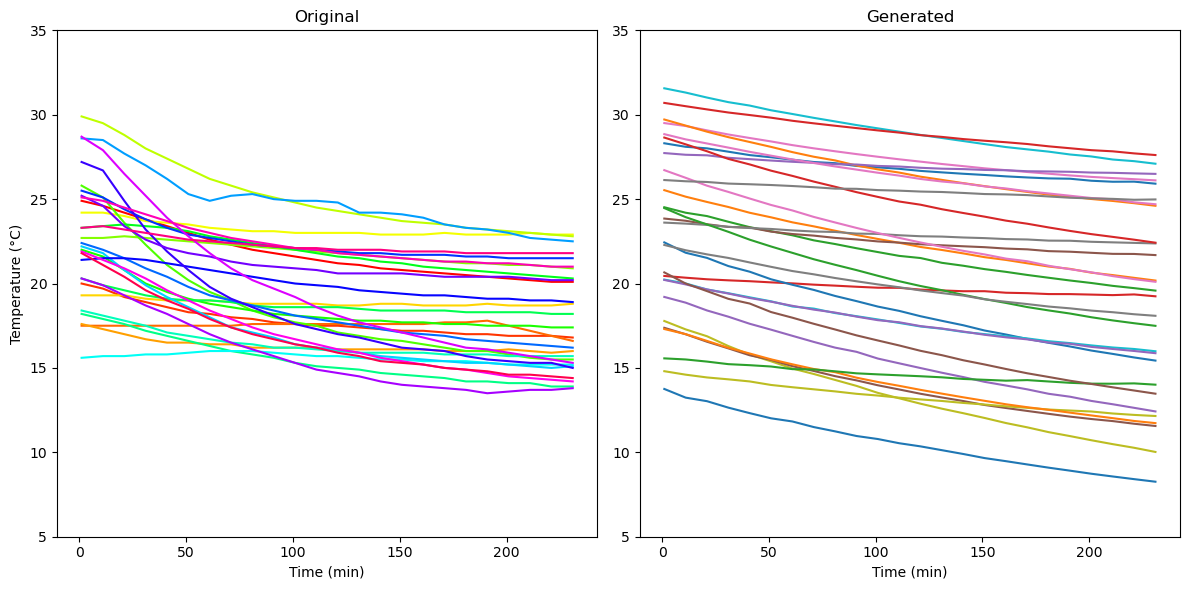

Training Progress:  10%|▉         | 59/600 [00:06<00:54,  9.96it/s]

Epoch 60: Train Loss = 1.2435, KL_phy = 0.2231, KL_delta = 0.0245, MSE = 1.2192, CE = 0.5715, Reg_Loss = 0.1340, Alpha = 0.0902
Validation Loss = 1.5700, Val_KL_phy = 0.2231, Val_KL_delta = 0.0763, Val_MSE = 1.5447, Val_CE = 0.5427, Val_Reg_Loss = 0.1173, Val_Alpha = 0.0901


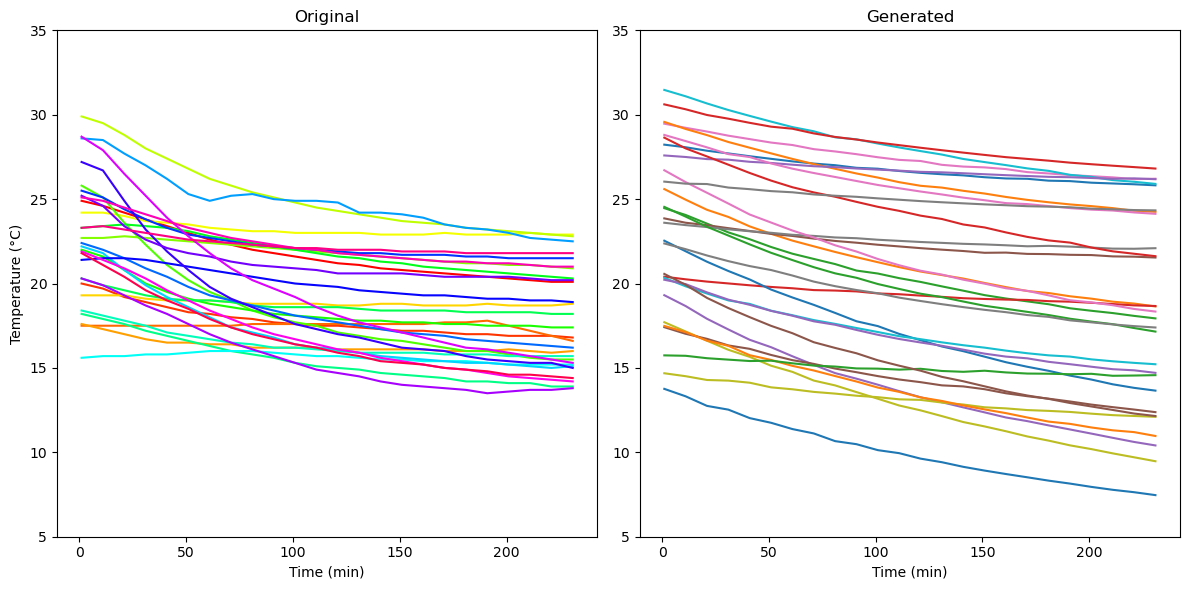

Training Progress:  15%|█▍        | 89/600 [00:09<00:50, 10.08it/s]

Epoch 90: Train Loss = 1.0997, KL_phy = 0.2814, KL_delta = 0.1082, MSE = 1.0436, CE = 0.2469, Reg_Loss = 0.3249, Alpha = 0.0835
Validation Loss = 1.5489, Val_KL_phy = 0.2795, Val_KL_delta = 0.1578, Val_MSE = 1.4979, Val_CE = 0.1911, Val_Reg_Loss = 0.2214, Val_Alpha = 0.0834


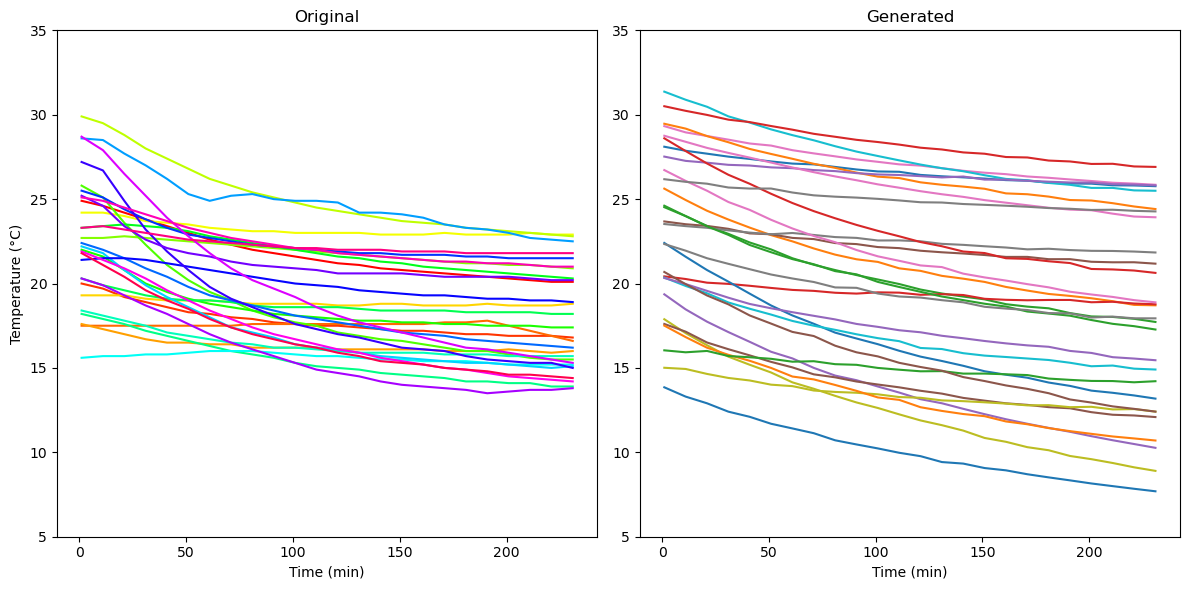

Training Progress:  20%|█▉        | 119/600 [00:12<00:47, 10.10it/s]

Epoch 120: Train Loss = 1.0453, KL_phy = 0.3354, KL_delta = 0.1755, MSE = 0.9498, CE = 0.1498, Reg_Loss = 0.5779, Alpha = 0.0775
Validation Loss = 1.1548, Val_KL_phy = 0.3313, Val_KL_delta = 0.2096, Val_MSE = 1.0777, Val_CE = 0.1086, Val_Reg_Loss = 0.3017, Val_Alpha = 0.0774


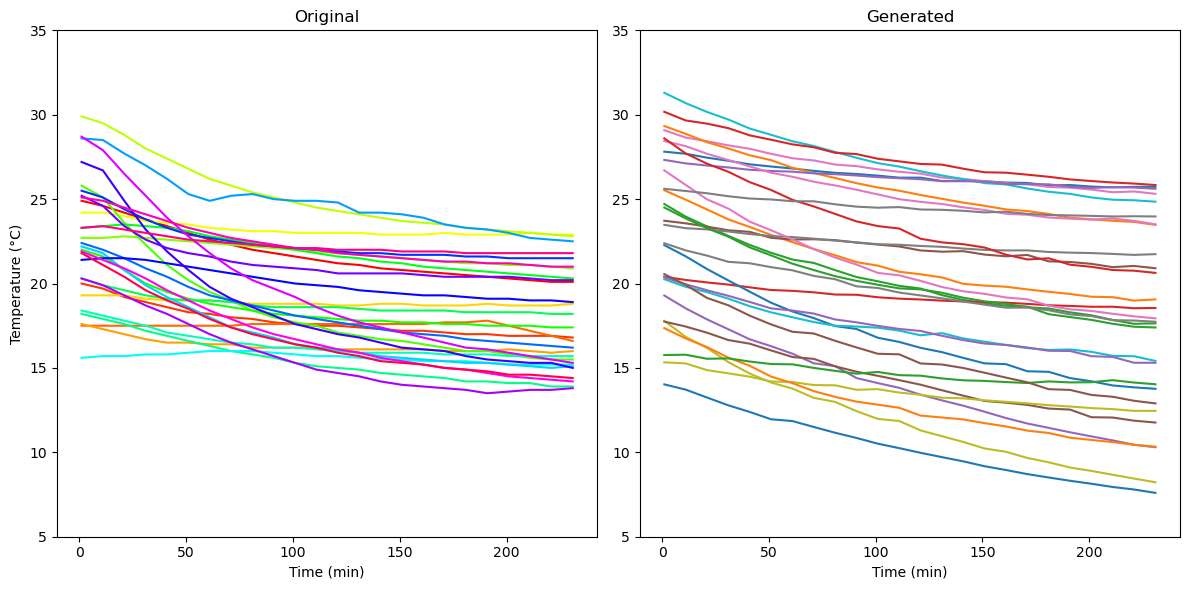

Training Progress:  25%|██▍       | 148/600 [00:15<00:44, 10.06it/s]

Epoch 150: Train Loss = 1.0195, KL_phy = 0.3474, KL_delta = 0.2058, MSE = 0.8881, CE = 0.0880, Reg_Loss = 0.8626, Alpha = 0.0725
Validation Loss = 1.1213, Val_KL_phy = 0.3444, Val_KL_delta = 0.2432, Val_MSE = 1.0137, Val_CE = 0.1134, Val_Reg_Loss = 0.4761, Val_Alpha = 0.0725


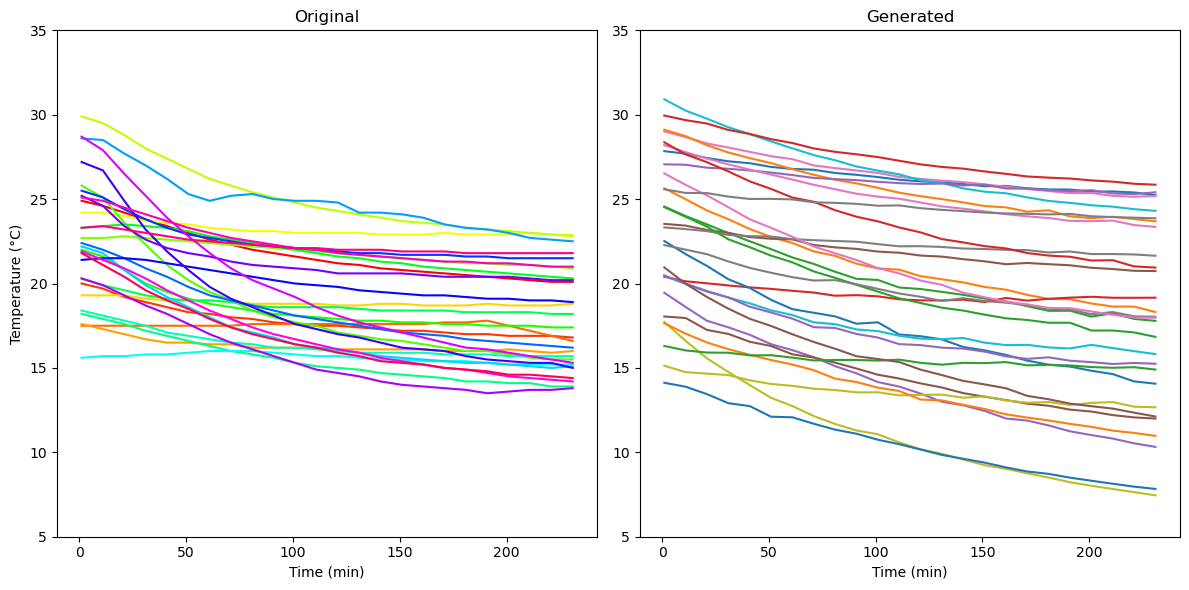

Training Progress:  30%|██▉       | 179/600 [00:18<00:42,  9.93it/s]

Epoch 180: Train Loss = 0.9968, KL_phy = 0.3157, KL_delta = 0.2121, MSE = 0.8575, CE = 0.0858, Reg_Loss = 0.8818, Alpha = 0.0686
Validation Loss = 1.0892, Val_KL_phy = 0.3126, Val_KL_delta = 0.2473, Val_MSE = 0.9808, Val_CE = 0.0900, Val_Reg_Loss = 0.3608, Val_Alpha = 0.0685


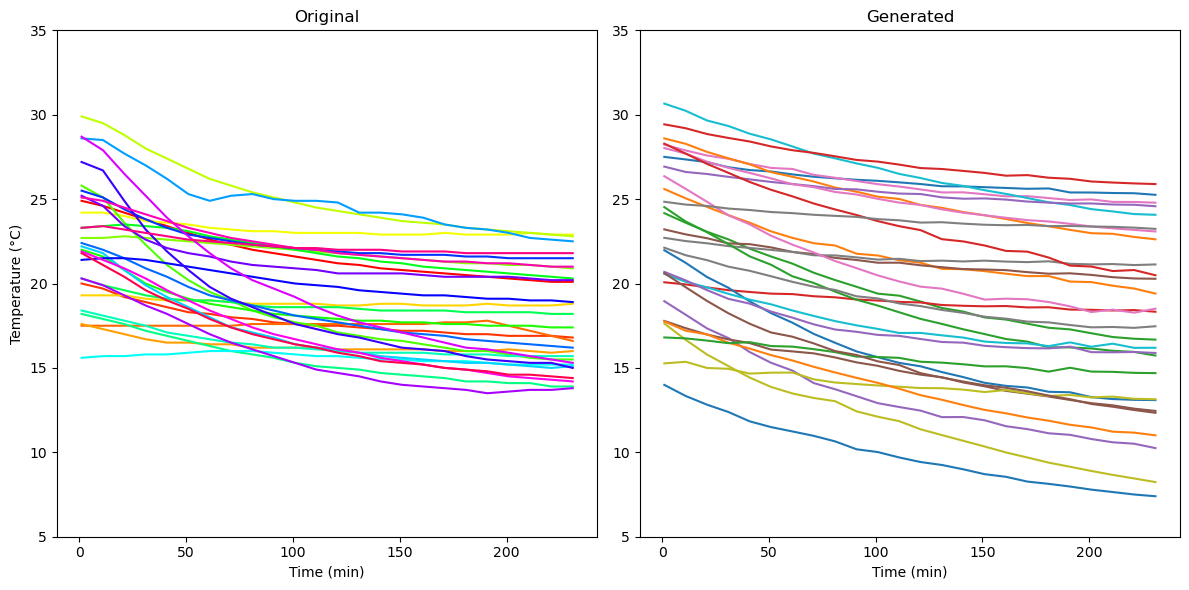

Training Progress:  35%|███▍      | 209/600 [00:22<00:39,  9.92it/s]

Epoch 210: Train Loss = 0.9960, KL_phy = 0.2895, KL_delta = 0.2365, MSE = 0.8388, CE = 0.0949, Reg_Loss = 1.0043, Alpha = 0.0651
Validation Loss = 1.1656, Val_KL_phy = 0.2905, Val_KL_delta = 0.2935, Val_MSE = 1.0430, Val_CE = 0.0847, Val_Reg_Loss = 0.3189, Val_Alpha = 0.0651


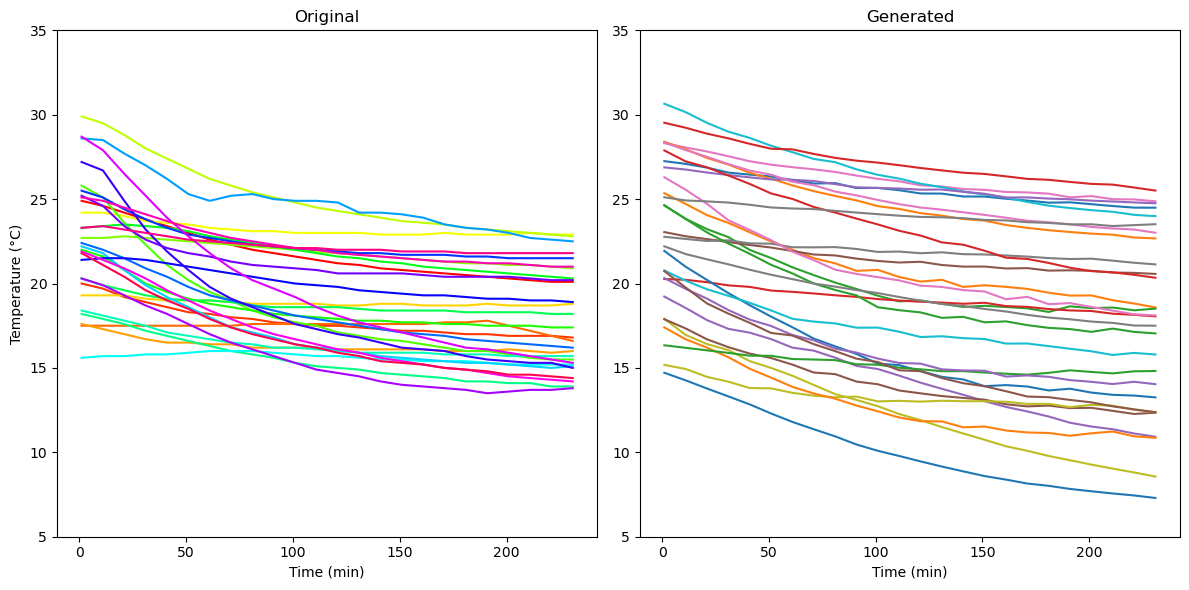

Training Progress:  40%|███▉      | 239/600 [00:25<00:36,  9.85it/s]

Epoch 240: Train Loss = 0.9130, KL_phy = 0.2711, KL_delta = 0.2680, MSE = 0.7471, CE = 0.1004, Reg_Loss = 0.9406, Alpha = 0.0620
Validation Loss = 1.2394, Val_KL_phy = 0.2702, Val_KL_delta = 0.3351, Val_MSE = 1.0937, Val_CE = 0.1138, Val_Reg_Loss = 0.4018, Val_Alpha = 0.0619


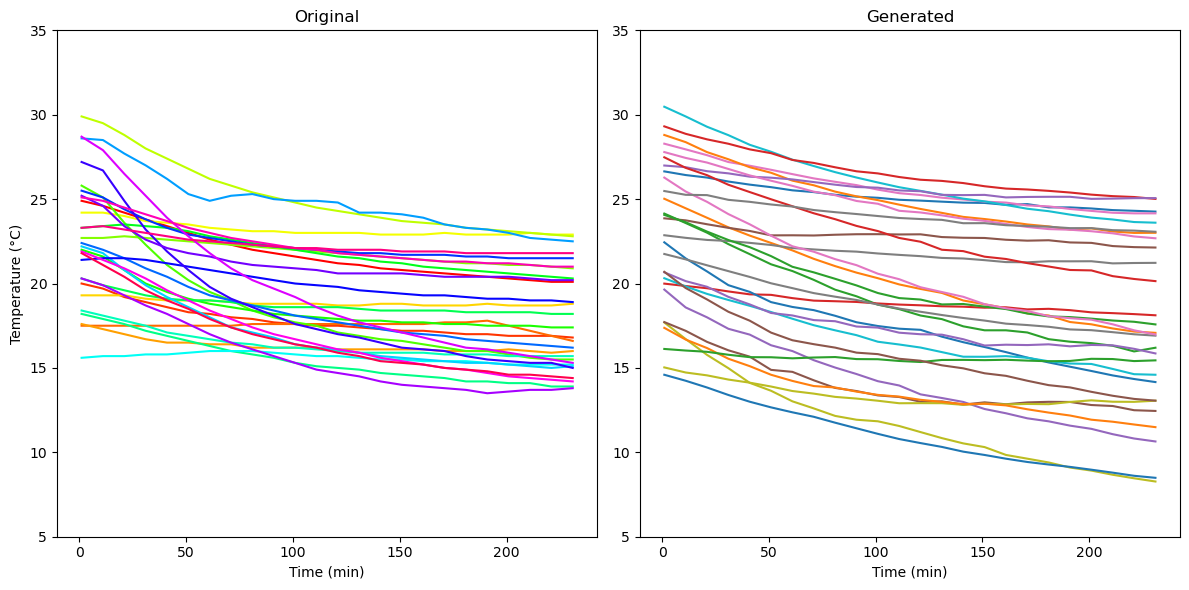

Training Progress:  45%|████▍     | 268/600 [00:28<00:33,  9.92it/s]

Epoch 270: Train Loss = 0.8792, KL_phy = 0.1942, KL_delta = 0.2801, MSE = 0.6950, CE = 0.0953, Reg_Loss = 1.3115, Alpha = 0.0593
Validation Loss = 0.8056, Val_KL_phy = 0.1967, Val_KL_delta = 0.3506, Val_MSE = 0.6599, Val_CE = 0.0980, Val_Reg_Loss = 0.3836, Val_Alpha = 0.0592


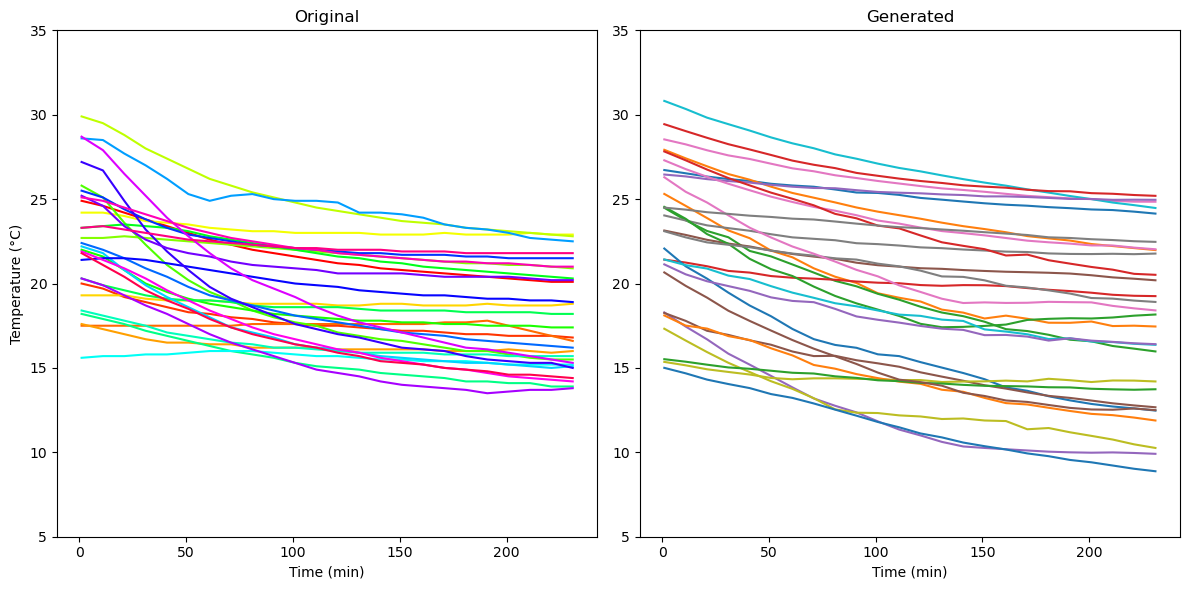

Training Progress:  50%|████▉     | 298/600 [00:31<00:30, 10.05it/s]

Epoch 300: Train Loss = 0.7825, KL_phy = 0.1282, KL_delta = 0.2683, MSE = 0.6299, CE = 0.1011, Reg_Loss = 0.9442, Alpha = 0.0568
Validation Loss = 0.8072, Val_KL_phy = 0.1294, Val_KL_delta = 0.3226, Val_MSE = 0.6728, Val_CE = 0.0916, Val_Reg_Loss = 0.3791, Val_Alpha = 0.0567


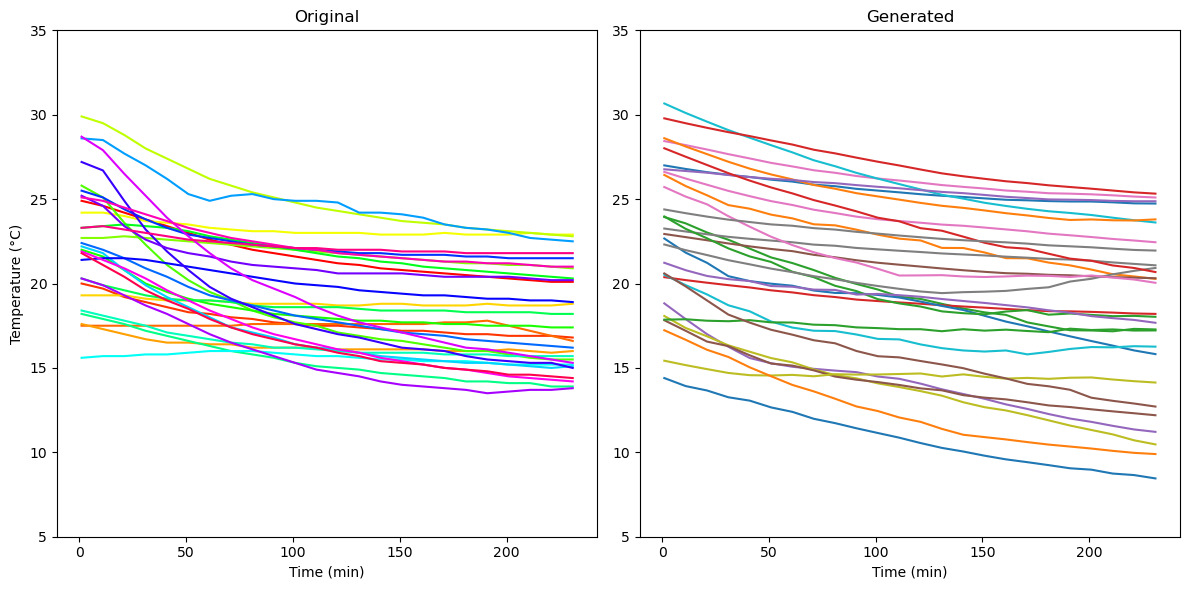

Training Progress:  55%|█████▍    | 329/600 [00:34<00:27,  9.98it/s]

Epoch 330: Train Loss = 0.7634, KL_phy = 0.1700, KL_delta = 0.2365, MSE = 0.5930, CE = 0.0751, Reg_Loss = 1.0815, Alpha = 0.0544
Validation Loss = 0.6811, Val_KL_phy = 0.1746, Val_KL_delta = 0.3142, Val_MSE = 0.5197, Val_CE = 0.0795, Val_Reg_Loss = 0.5011, Val_Alpha = 0.0543


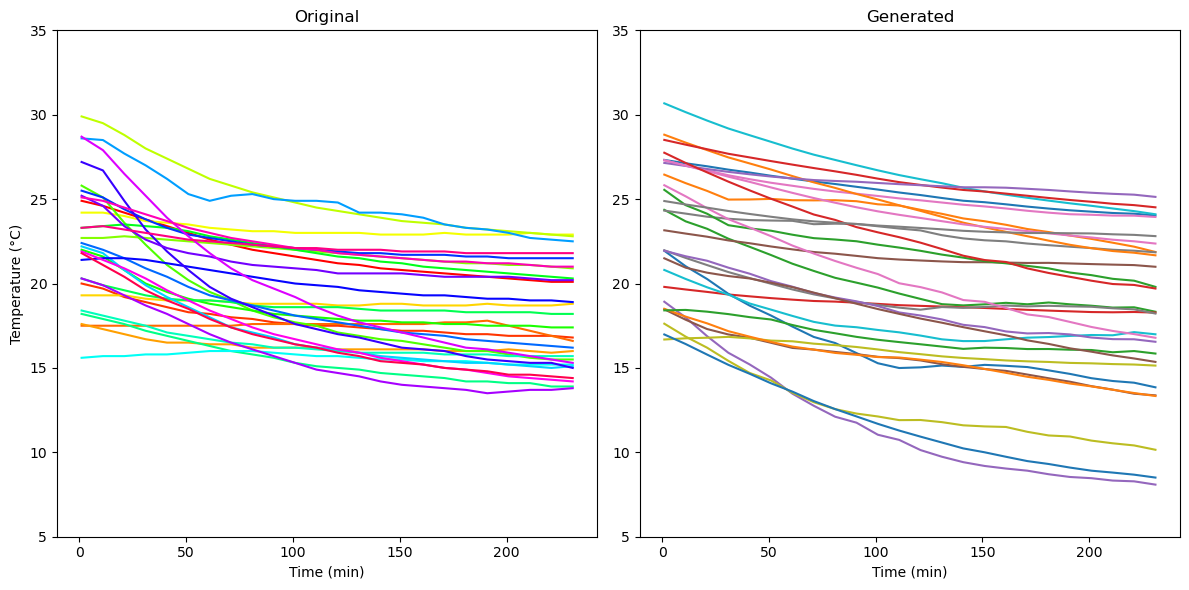

Training Progress:  60%|█████▉    | 359/600 [00:37<00:24,  9.96it/s]

Epoch 360: Train Loss = 0.6587, KL_phy = 0.1437, KL_delta = 0.2046, MSE = 0.4983, CE = 0.0680, Reg_Loss = 1.0745, Alpha = 0.0521
Validation Loss = 0.6206, Val_KL_phy = 0.1394, Val_KL_delta = 0.2833, Val_MSE = 0.4683, Val_CE = 0.0749, Val_Reg_Loss = 0.4902, Val_Alpha = 0.0521


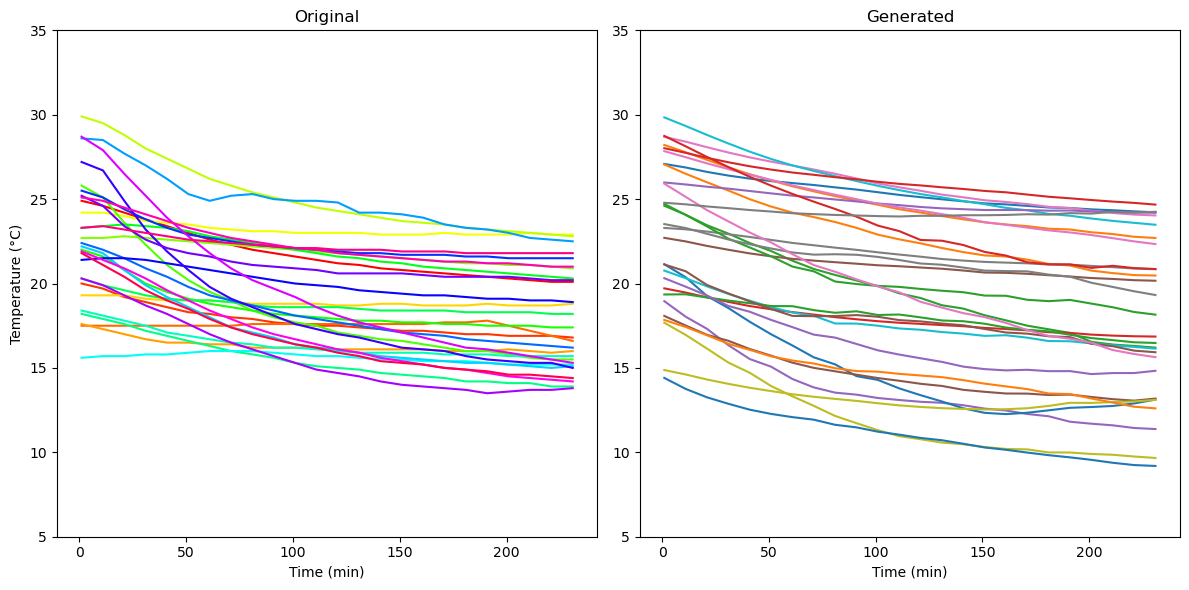

Training Progress:  65%|██████▍   | 389/600 [00:41<00:21,  9.90it/s]

Epoch 390: Train Loss = 0.8235, KL_phy = 0.1276, KL_delta = 0.1868, MSE = 0.6499, CE = 0.0695, Reg_Loss = 1.4289, Alpha = 0.0501
Validation Loss = 0.6645, Val_KL_phy = 0.1491, Val_KL_delta = 0.2481, Val_MSE = 0.5095, Val_CE = 0.0620, Val_Reg_Loss = 0.5192, Val_Alpha = 0.0500


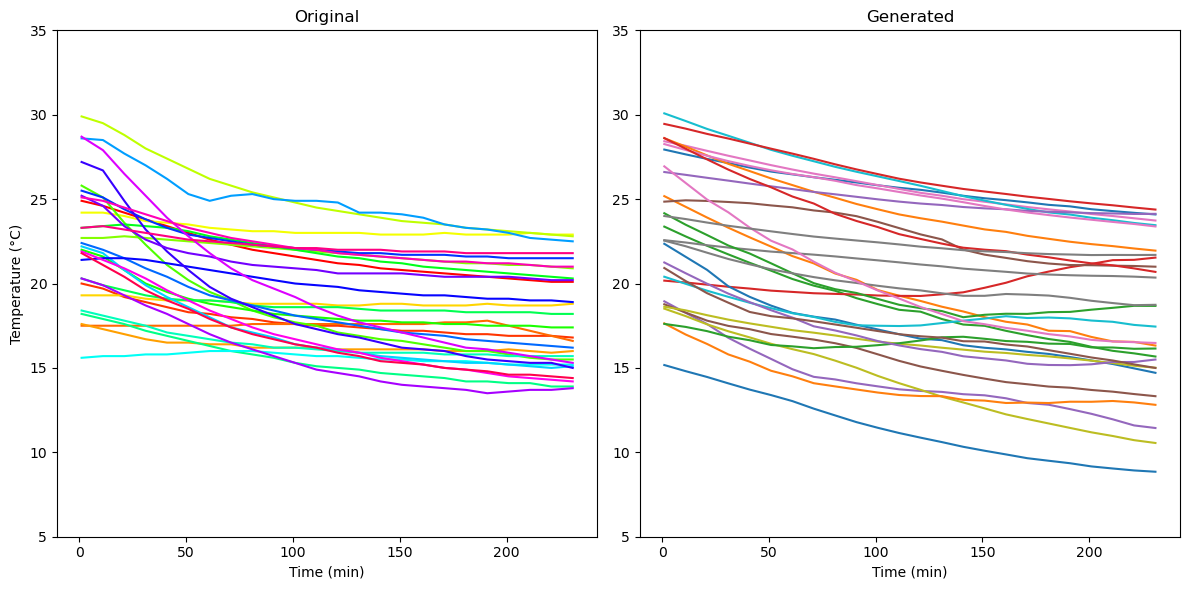

Training Progress:  70%|██████▉   | 419/600 [00:44<00:18,  9.86it/s]

Epoch 420: Train Loss = 0.6923, KL_phy = 0.0974, KL_delta = 0.1566, MSE = 0.5324, CE = 0.0558, Reg_Loss = 1.4764, Alpha = 0.0481
Validation Loss = 0.6228, Val_KL_phy = 0.1020, Val_KL_delta = 0.2118, Val_MSE = 0.4951, Val_CE = 0.0594, Val_Reg_Loss = 0.3724, Val_Alpha = 0.0481


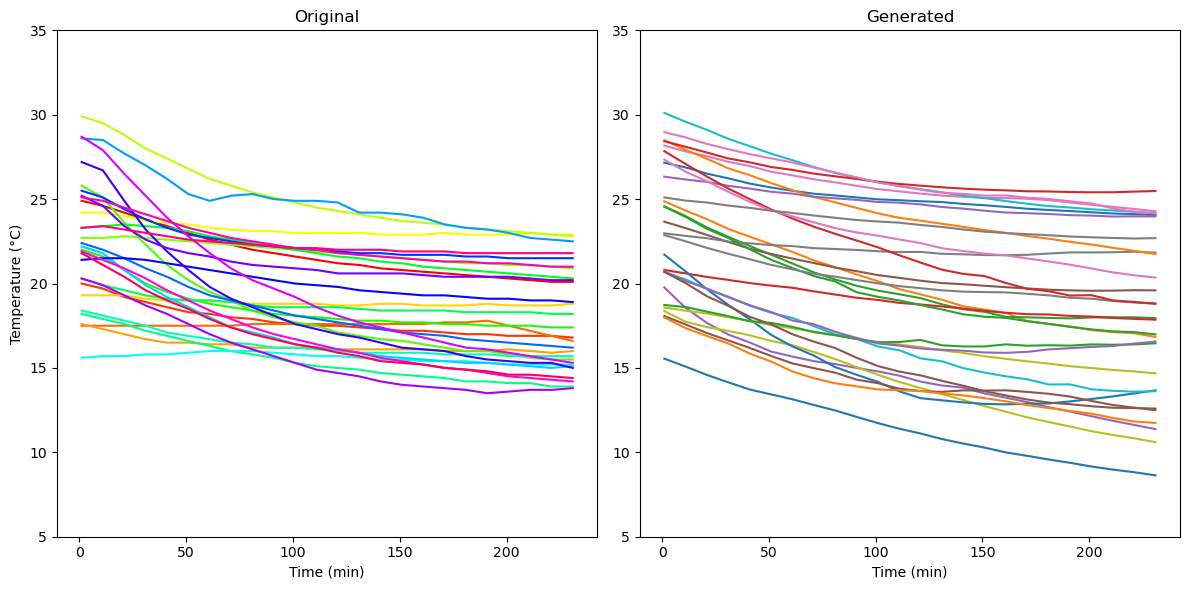

Training Progress:  75%|███████▍  | 449/600 [00:47<00:15,  9.91it/s]

Epoch 450: Train Loss = 0.7213, KL_phy = 0.1084, KL_delta = 0.1205, MSE = 0.5929, CE = 0.0419, Reg_Loss = 0.9190, Alpha = 0.0462
Validation Loss = 0.5119, Val_KL_phy = 0.1063, Val_KL_delta = 0.1973, Val_MSE = 0.3745, Val_CE = 0.0614, Val_Reg_Loss = 0.5106, Val_Alpha = 0.0462


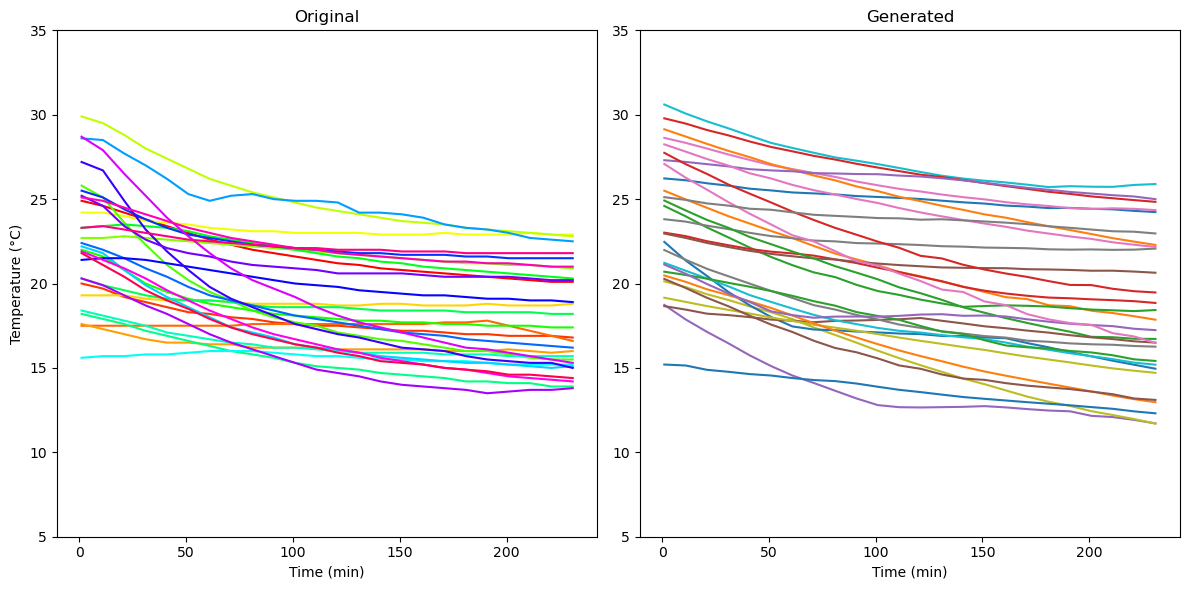

Training Progress:  80%|███████▉  | 479/600 [00:50<00:12,  9.89it/s]

Epoch 480: Train Loss = 0.6138, KL_phy = 0.0875, KL_delta = 0.0983, MSE = 0.4899, CE = 0.0373, Reg_Loss = 1.1142, Alpha = 0.0445
Validation Loss = 0.4903, Val_KL_phy = 0.0880, Val_KL_delta = 0.1654, Val_MSE = 0.3658, Val_CE = 0.0546, Val_Reg_Loss = 0.5211, Val_Alpha = 0.0445


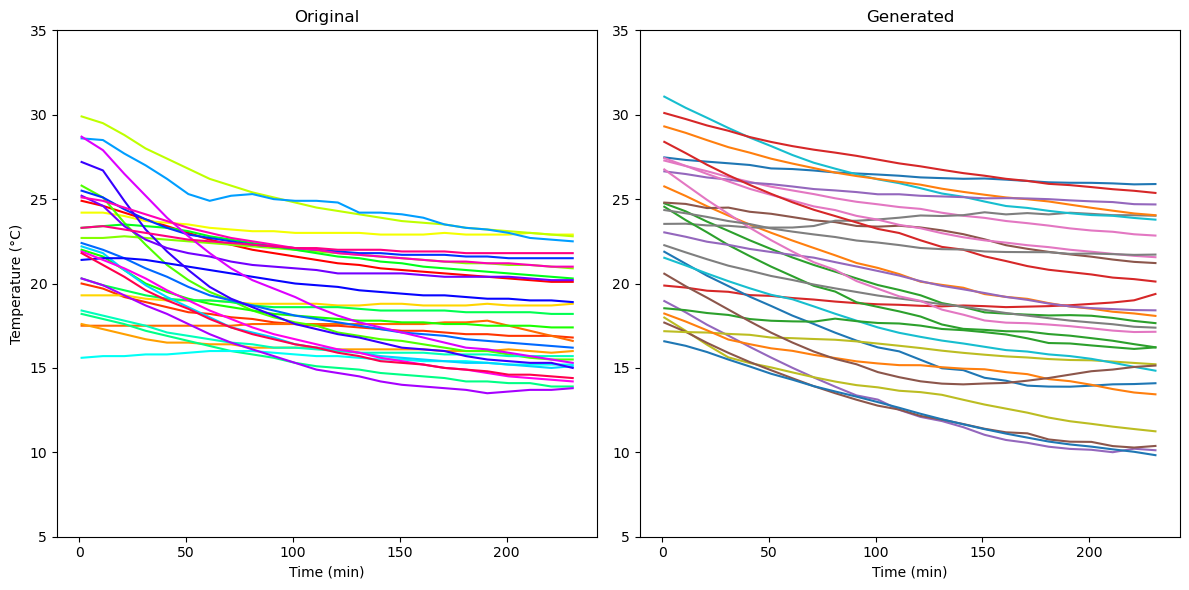

Training Progress:  85%|████████▍ | 509/600 [00:53<00:09,  9.93it/s]

Epoch 510: Train Loss = 0.6704, KL_phy = 0.0889, KL_delta = 0.0849, MSE = 0.5417, CE = 0.0358, Reg_Loss = 1.2799, Alpha = 0.0429
Validation Loss = 0.6531, Val_KL_phy = 0.1004, Val_KL_delta = 0.1401, Val_MSE = 0.5184, Val_CE = 0.0477, Val_Reg_Loss = 0.7593, Val_Alpha = 0.0428


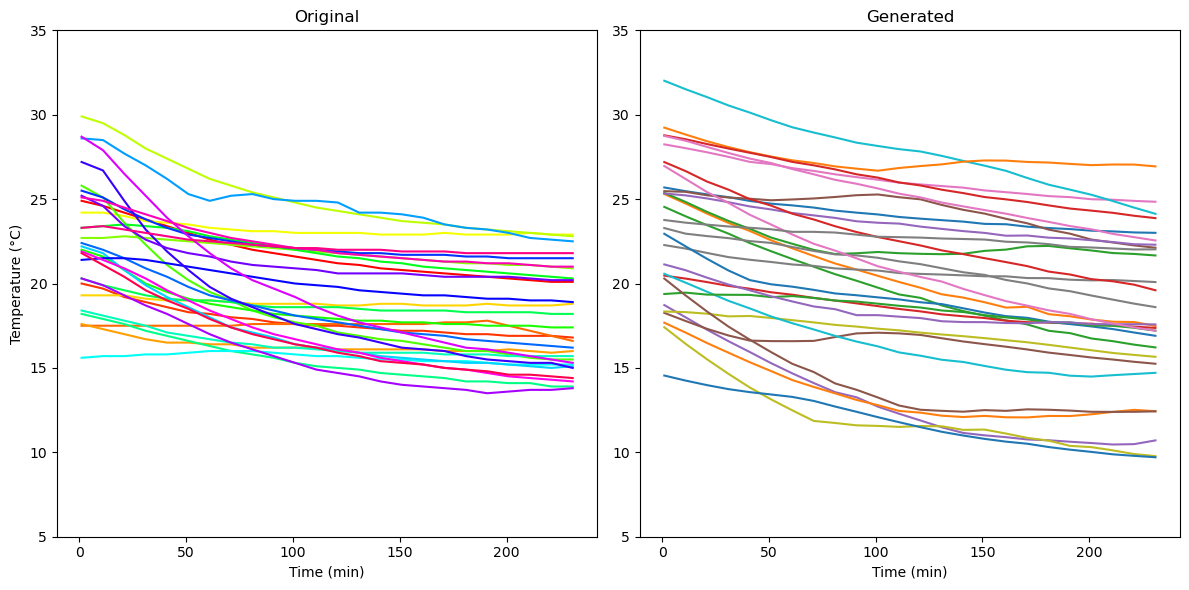

Training Progress:  90%|████████▉ | 539/600 [00:57<00:06,  9.87it/s]

Epoch 540: Train Loss = 0.6496, KL_phy = 0.0737, KL_delta = 0.0632, MSE = 0.5256, CE = 0.0330, Reg_Loss = 1.5135, Alpha = 0.0413
Validation Loss = 0.5650, Val_KL_phy = 0.0765, Val_KL_delta = 0.1185, Val_MSE = 0.4453, Val_CE = 0.0429, Val_Reg_Loss = 0.7754, Val_Alpha = 0.0412


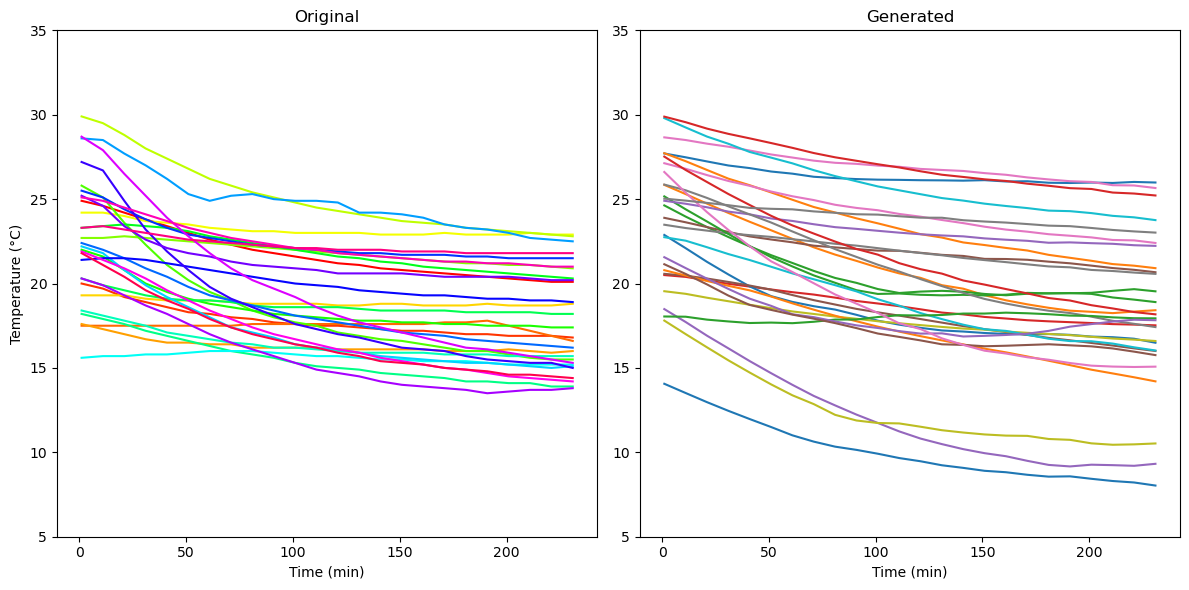

Training Progress:  95%|█████████▍| 569/600 [01:00<00:03,  9.90it/s]

Epoch 570: Train Loss = 0.6467, KL_phy = 0.0827, KL_delta = 0.0418, MSE = 0.5273, CE = 0.0461, Reg_Loss = 1.5210, Alpha = 0.0397
Validation Loss = 0.9186, Val_KL_phy = 0.0870, Val_KL_delta = 0.0970, Val_MSE = 0.8062, Val_CE = 0.0409, Val_Reg_Loss = 0.6297, Val_Alpha = 0.0396


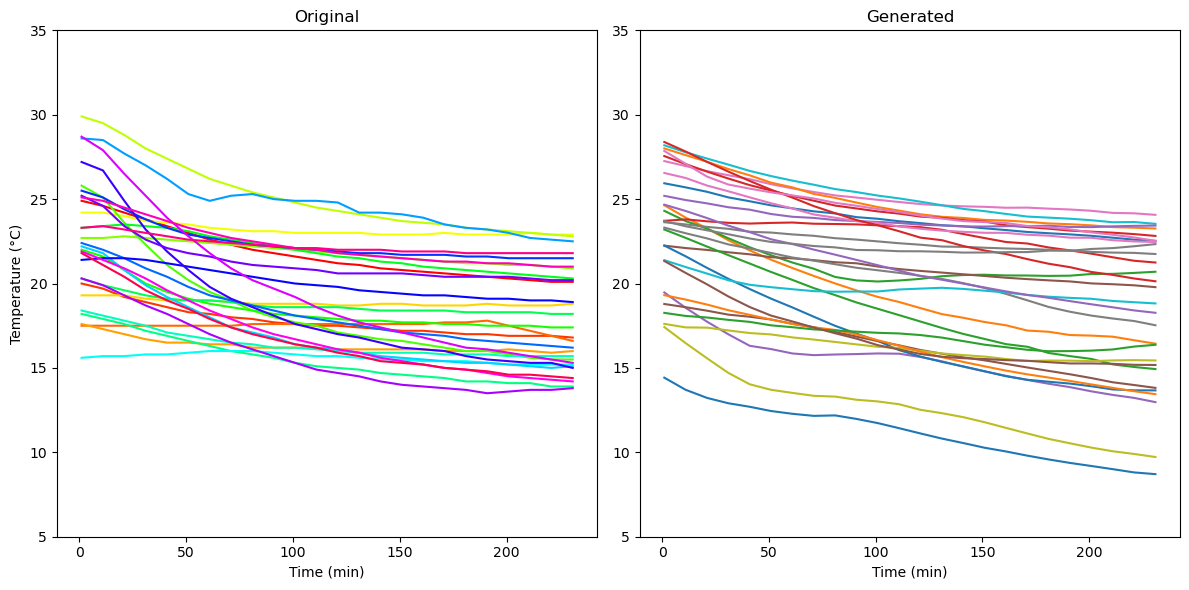

Training Progress: 100%|█████████▉| 599/600 [01:03<00:00,  9.79it/s]

Epoch 600: Train Loss = 0.6674, KL_phy = 0.0759, KL_delta = 0.0262, MSE = 0.5514, CE = 0.0289, Reg_Loss = 1.7022, Alpha = 0.0382
Validation Loss = 0.6830, Val_KL_phy = 0.0784, Val_KL_delta = 0.0886, Val_MSE = 0.5802, Val_CE = 0.0405, Val_Reg_Loss = 0.5055, Val_Alpha = 0.0381


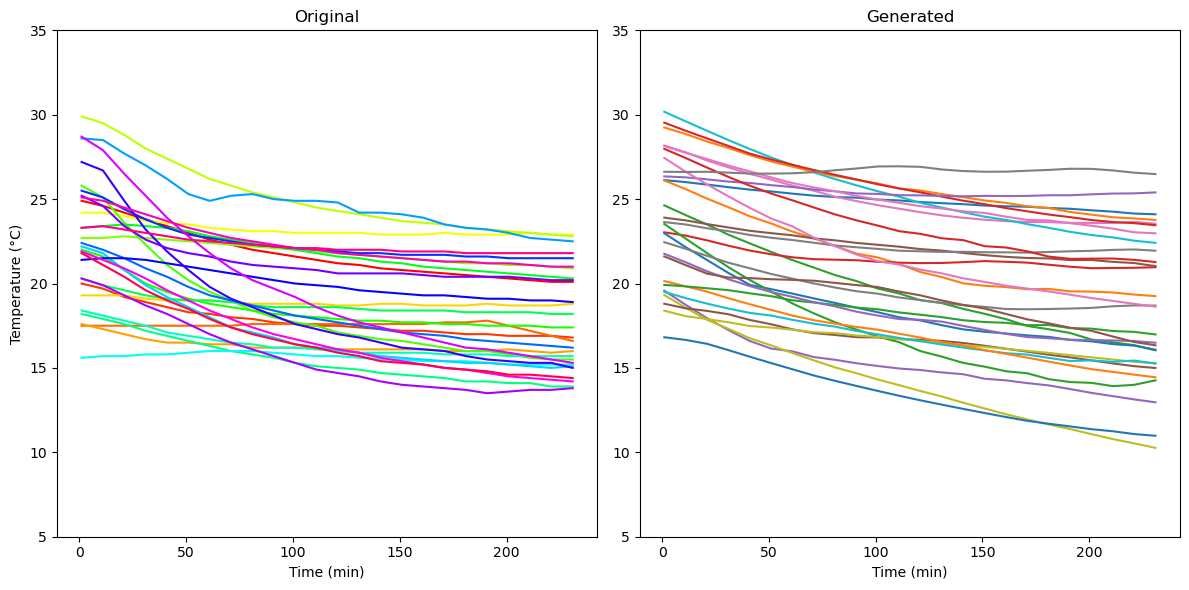

Training Progress: 100%|██████████| 600/600 [01:03<00:00,  9.41it/s]


In [9]:
num_epochs=600
epochs=range(num_epochs)

annealing_strategy = AnnealingStrategy(strategy='linear', 
                                       total_epochs=num_epochs, 
                                       beta_min=0.0001, 
                                       beta_max=0.5)
beta_annealed = annealing_strategy.get_beta_vector()
# beta_annealed = torch.tensor(beta_annealed)
beta_delta=beta_annealed
beta_phy=beta_annealed
ns = total_size
min_T, max_T = 13, 32
T0 = min_T + (max_T - min_T) * torch.rand(ns)
difference = 1 + (15 - 1) * torch.rand(ns)
Ts = T0 - difference
unique_intervals = df_c['interval'].unique()
num_unique_intervals = len(unique_intervals)

fit_res = model.fit(train_loader=train_loader, 
                    val_loader=val_loader, 
                    opt=opt, 
                    beta_delta=beta_delta,
                    beta_phy=beta_phy,
                    num_epochs=num_epochs,
                   seed=0, plot=True, df=df_c, ns=ns, T0=T0, Ts=Ts, t_uni=t_uni/240, axs_ylim=(5, 35))
# !!! Make it works with plot=True

In [10]:
fit_res['alpha_values'][-1]

0.03815449774265289

In [ ]:
# torch.save(model.state_dict(), 'pre_trained_models/PIGPVAE_cooling.pth')